In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [43]:
def scale_standard(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled


def scale_minmax(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled


In [44]:
# PCA
def apply_pca(df):
    pca = PCA(n_components=2)
    features = pca.fit_transform(df)
    return features

In [45]:
DF = pd.concat([pd.read_csv(f, encoding='UTF-8') for f in ['newcombined_jlm.csv' ,'combined_test.csv', 'combined_perf.csv']], axis=1)

In [46]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12599 entries, 0 to 12598
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      12599 non-null  int64  
 1   %MISS           12599 non-null  int64  
 2   GETS            12599 non-null  int64  
 3   NONREC          12599 non-null  int64  
 4   SLOW            12599 non-null  int64  
 5   REC             12599 non-null  int64  
 6   TIER2           12599 non-null  int64  
 7   TIER3           12599 non-null  int64  
 8   %UTIL           12599 non-null  int64  
 9   AVER_HTM        12599 non-null  int64  
 10  MON-NAME        12599 non-null  object 
 11  PATTERN-NAME    12599 non-null  object 
 12  PATTERN-NO      12599 non-null  int64  
 13  THREADS         1400 non-null   float64
 14  SLEEP           1400 non-null   float64
 15  _raw_spin_lock  12599 non-null  int64  
 16  ctx_sched_in    12599 non-null  int64  
 17  delay_mwaitx    12599 non-null 

In [10]:
sum_columns = DF["TIER2"] + DF["TIER3"]
DF["SPIN_COUNT"] = sum_columns
#DF.drop('SpinCount', inplace=True, axis=1)
DF.head()


,Unnamed: 0,%MISS,GETS,NONREC,SLOW,REC,TIER2,TIER3,%UTIL,AVER_HTM,MON-NAME,PATTERN-NAME,PATTERN-NO,THREADS,SLEEP,_raw_spin_lock,ctx_sched_in,delay_mwaitx,SPIN_COUNT
0,0,3,77796,77796,2018,0,61982420,1896924,99,484343,java/lang/Object@000000060A261730,Hot2,2,400.0,1100.0,319,214,456,63879344
1,1,3,73161,73161,2260,0,59652812,1826731,99,515373,java/lang/Object@000000060A25B2F8,Hot2,2,300.0,4700.0,342,186,376,61479543
2,2,4,68707,68707,2834,0,63720192,1955842,99,547316,java/lang/Object@000000060A25AFC0,Hot2,2,1000.0,8600.0,342,170,382,65676034
3,3,3,75964,75964,2221,0,61436292,1881719,99,496400,java/lang/Object@000000060A25B5F0,Hot2,2,300.0,2700.0,392,137,412,63318011
4,4,5,69896,69896,3723,0,71368846,2193941,99,537829,java/lang/Object@000000060A25B498,Hot2,2,1000.0,7800.0,405,91,374,73562787


In [33]:
DF["SLOW"].mean()/DF["GETS"].mean()

0.01113259098704438

In [34]:
DF["%UTIL"].mean()/100

0.9057647432335899

In [11]:
DF.drop(DF.columns[DF.columns.str.contains('Unnamed:',case = False)],axis = 1, inplace = True)
DF.head()

,%MISS,GETS,NONREC,SLOW,REC,TIER2,TIER3,%UTIL,AVER_HTM,MON-NAME,PATTERN-NAME,PATTERN-NO,THREADS,SLEEP,_raw_spin_lock,ctx_sched_in,delay_mwaitx,SPIN_COUNT
0,3,77796,77796,2018,0,61982420,1896924,99,484343,java/lang/Object@000000060A261730,Hot2,2,400.0,1100.0,319,214,456,63879344
1,3,73161,73161,2260,0,59652812,1826731,99,515373,java/lang/Object@000000060A25B2F8,Hot2,2,300.0,4700.0,342,186,376,61479543
2,4,68707,68707,2834,0,63720192,1955842,99,547316,java/lang/Object@000000060A25AFC0,Hot2,2,1000.0,8600.0,342,170,382,65676034
3,3,75964,75964,2221,0,61436292,1881719,99,496400,java/lang/Object@000000060A25B5F0,Hot2,2,300.0,2700.0,392,137,412,63318011
4,5,69896,69896,3723,0,71368846,2193941,99,537829,java/lang/Object@000000060A25B498,Hot2,2,1000.0,7800.0,405,91,374,73562787


In [19]:
DF1 = DF.copy()
DF1 = DF1[['%MISS', 'GETS', 'SLOW', 'NONREC', 'REC', 'TIER2', 'TIER3', '%UTIL', 'AVER_HTM', 'PATTERN-NAME', 'PATTERN-NO', '_raw_spin_lock', 'ctx_sched_in', 'delay_mwaitx', 'THREADS', 'SLEEP', 'SPIN_COUNT']]
DF1 = DF1.rename(columns = {'_raw_spin_lock' : 'RAW_SPIN_LOCK', 'ctx_sched_in' : 'CTX_SWITCH', 'delay_mwaitx' : 'DELAY_MWAITX'})

DF_train = DF1[['GETS', 'SPIN_COUNT', 'NONREC', '%UTIL', 'AVER_HTM', 'PATTERN-NO', 'PATTERN-NAME', 'RAW_SPIN_LOCK', 'CTX_SWITCH', 'DELAY_MWAITX']]

In [20]:
DF_train.head()

,GETS,SPIN_COUNT,NONREC,%UTIL,AVER_HTM,PATTERN-NO,PATTERN-NAME,RAW_SPIN_LOCK,CTX_SWITCH,DELAY_MWAITX
0,77796,63879344,77796,99,484343,2,Hot2,319,214,456
1,73161,61479543,73161,99,515373,2,Hot2,342,186,376
2,68707,65676034,68707,99,547316,2,Hot2,342,170,382
3,75964,63318011,75964,99,496400,2,Hot2,392,137,412
4,69896,73562787,69896,99,537829,2,Hot2,405,91,374


In [14]:
cols = []
for col in DF_train.columns:
        cols.append(col)

DF_train[cols] = scale_standard(DF_train[cols])
DF_train.head()

/usr/local/pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,GETS,SPIN_COUNT,NONREC,%UTIL,AVER_HTM,PATTERN-NO,RAW_SPIN_LOCK,CTX_SWITCH,DELAY_MWAITX
0,-0.912293,-0.091389,-0.912293,0.340746,1.526858,-1.161938,1.030255,2.644511,-0.233422
1,-1.010355,-0.213626,-1.010355,0.340746,1.796083,-1.161938,1.237228,2.115595,-0.505893
2,-1.104588,0.000128,-1.104588,0.340746,2.073229,-1.161938,1.237228,1.813358,-0.485458
3,-0.951052,-0.119981,-0.951052,0.340746,1.631468,-1.161938,1.687168,1.189993,-0.383281
4,-1.079433,0.401852,-1.079433,0.340746,1.990917,-1.161938,1.804153,0.321060,-0.512705


In [15]:
pca_DF_train = pd.DataFrame(data = apply_pca(DF_train), columns = ['pc1', 'pc2'])
# pca_df_test = pd.DataFrame(data = apply_pca(df_pred), columns = ['pc1', 'pc2'])

print(pca_DF_train)

            pc1       pc2
0      1.935004  2.895998
1      2.177342  2.802057
2      2.192149  2.812245
3      1.928382  2.471352
4      1.845041  2.369252
...         ...       ...
12594 -1.319756 -0.632000
12595 -0.848297 -0.425531
12596 -1.468487 -0.819449
12597 -0.876275 -0.799385
12598 -1.273357 -0.509133

[12599 rows x 2 columns]


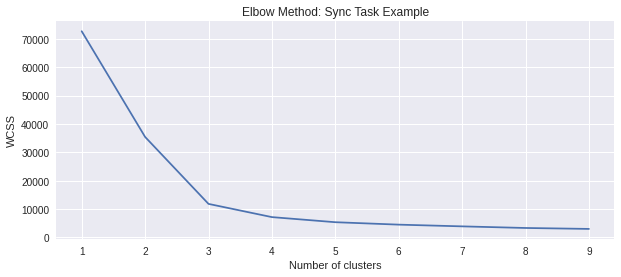

In [13]:
wcss1 = []
for i in range(1, 10):
    kmeans1 = KMeans(n_clusters=i, init='k-means++', max_iter=600, n_init=10)
    kmeans1.fit(pca_DF_train)
    wcss1.append(kmeans1.inertia_)
    

# %matplotlib inline
plt.figure(figsize = (10,4))
plt.style.use('seaborn')
plt.plot(range(1, 10), wcss1)
plt.title('Elbow Method: Sync Task Example')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 10), wcss1, curve="convex", direction="decreasing"
)
kl.elbow

3

In [15]:
pip intall kneed

ERROR: unknown command "intall" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install kneed

You should consider upgrading via the '/usr/local/pyenv/versions/3.7.9/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


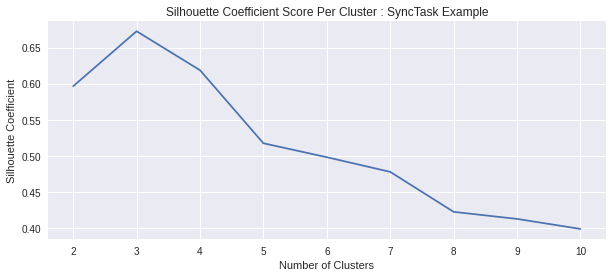

In [93]:
# silhouette coefficients
silhouette_coefficients1 = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans11 = KMeans(n_clusters=k, init='k-means++', max_iter=600, n_init=10)
    kmeans11.fit(pca_DF_train)
    score = silhouette_score(pca_DF_train, kmeans11.labels_)
    silhouette_coefficients1.append(score)

plt.figure(figsize = (10,4))
plt.style.use("seaborn")
plt.plot(range(2, 11), silhouette_coefficients1)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient Score Per Cluster : SyncTask Example")
plt.show()

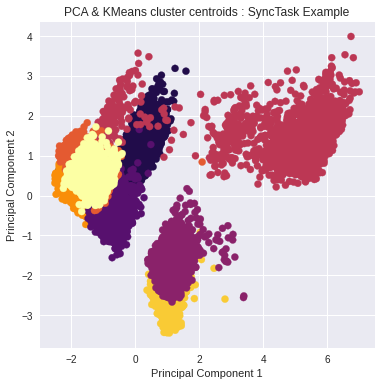

In [51]:
kmeans12 = KMeans(n_clusters=3, init='k-means++', max_iter=600, n_init=10)
kmeans12.fit(pca_DF_train)

# Plotting the cluster centers and the data points on a 2D plane
plt.figure(figsize = (6,6))
plt.style.use("seaborn")
plt.scatter(pca_DF_train['pc1'], pca_DF_train['pc2'], s=50, c=DF_train['PATTERN-NO'], cmap="inferno")


#plt.scatter(kmeans12.cluster_centers_[:, 0], kmeans12.cluster_centers_[:, 1], c='red', marker='o')
    
plt.title('PCA & KMeans cluster centroids : SyncTask Example')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

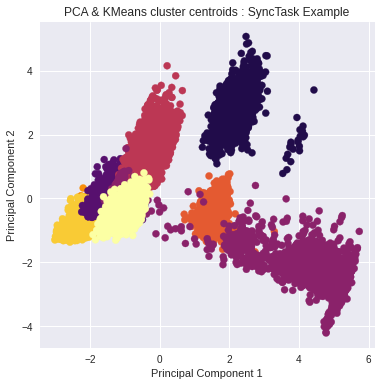

In [47]:
kmeans12 = KMeans(n_clusters=9, init='k-means++', max_iter=600, n_init=10)
kmeans12.fit(pca_DF_train)

# Plotting the cluster centers and the data points on a 2D plane
plt.figure(figsize = (6,6))
plt.style.use("seaborn")
plt.scatter(pca_DF_train['pc1'], pca_DF_train['pc2'], s=50, c=DF_train['PATTERN-NO'], cmap="inferno")


#plt.scatter(kmeans12.cluster_centers_[:, 0], kmeans12.cluster_centers_[:, 1], c='red', marker='o')
    
plt.title('PCA & KMeans cluster centroids : SyncTask Example')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

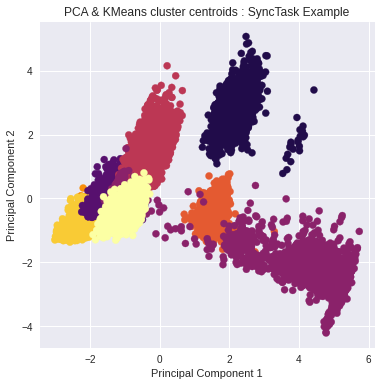

In [26]:
kmeans12 = KMeans(n_clusters=3, init='k-means++', max_iter=600, n_init=10)
kmeans12.fit(pca_DF_train)

# Plotting the cluster centers and the data points on a 2D plane
plt.figure(figsize = (6,6))
plt.style.use("seaborn")
plt.scatter(pca_DF_train['pc1'], pca_DF_train['pc2'], s=50, c=DF_train['PATTERN-NO'], cmap="inferno")


#plt.scatter(kmeans12.cluster_centers_[:, 0], kmeans12.cluster_centers_[:, 1], c='red', marker='o')
    
plt.title('PCA & KMeans cluster centroids : SyncTask Example')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [21]:
df = pd.DataFrame({'x': pca_DF_train['pc1'], 'y': pca_DF_train['pc2'], 'z': DF_train['PATTERN-NAME']})
df
            


,x,y,z
0,1.935004,2.895998,Hot2
1,2.177342,2.802057,Hot2
2,2.192149,2.812245,Hot2
3,1.928382,2.471352,Hot2
4,1.845041,2.369252,Hot2
...,...,...,...
12594,-1.319756,-0.632000,Unpredict
12595,-0.848297,-0.425531,Unpredict
12596,-1.468487,-0.819449,Unpredict
12597,-0.876275,-0.799385,Unpredict


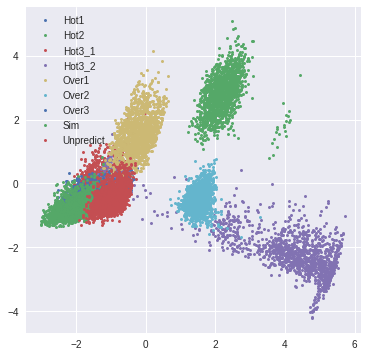

In [51]:
plt.figure(figsize = (6,6))
#plt.style.use("seaborn")
sns.color_palette("Paired")
groups = df.groupby('z')

for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=3, label=name)

plt.legend()

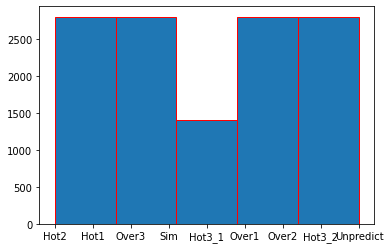

In [15]:
import matplotlib.pyplot as plt
x = [DF_train['PATTERN-NAME']]
plt.hist(x, edgecolor="red", bins=5)
plt.show()

In [17]:
data = [DF_train['PATTERN-NO']]
binwidth = 8
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth),
         edgecolor="yellow", color="brown")
  
plt.show()

TypeError: 'Series' object cannot be interpreted as an integer

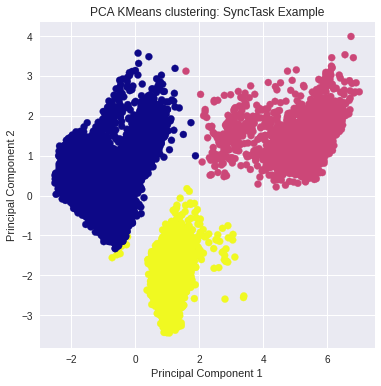

In [107]:
plt.figure(figsize = (6,6))
plt.style.use("seaborn")
plt.scatter(pca_DF_train['pc1'], pca_DF_train['pc2'], c=kmeans12.labels_, cmap="plasma")
plt.title('PCA KMeans clustering: SyncTask Example')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [110]:
kmeans13 = KMeans(n_clusters=3, init='k-means++', max_iter=600, n_init=10)
kmeans13.fit(pca_DF_train)
DF1['CLUSTER_TYPE'] = pd.Series(kmeans13.labels_, index=DF1.index)

DF1.head(20)

,%MISS,GETS,SLOW,NONREC,REC,TIER2,TIER3,%UTIL,AVER_HTM,RAW_SPIN_LOCK,CTX_SWITCH,DELAY_MWAITX,THREADS,SLEEP,SPIN_COUNT,CLUSTER_TYPE
0,0,152766,148,152766,0,71701872,2166099,100,247711,319,214,456,300,158001,73867971,0
1,0,139146,95,139146,0,71079422,2154875,100,272032,342,186,376,500,26001,73234297,0
2,0,135255,99,135255,0,70971264,2153589,100,279883,342,170,382,400,70001,73124853,0
3,0,144309,105,144309,0,71853300,2177412,100,262419,392,137,412,1000,1,74030712,0
4,0,129804,76,129804,0,70814207,2149844,100,291760,405,91,374,1000,178001,72964051,0
5,0,118416,71,118416,0,69562029,2116515,100,319923,287,235,404,300,114001,71678544,0
6,0,135578,97,135578,0,70757545,2147762,100,279260,372,220,355,10,108001,72905307,0
7,0,146060,114,146060,0,68191119,2062605,100,259336,346,124,386,200,182001,70253724,0
8,0,137266,77,137266,0,71131525,2157044,100,275780,416,146,365,300,182001,73288569,0
9,0,120501,62,120501,0,70213626,2137774,100,314364,348,58,347,400,53001,72351400,0


<AxesSubplot:title={'center':'Observe Dominant Features: Radial Visualization for clusters from KMeans only'}>

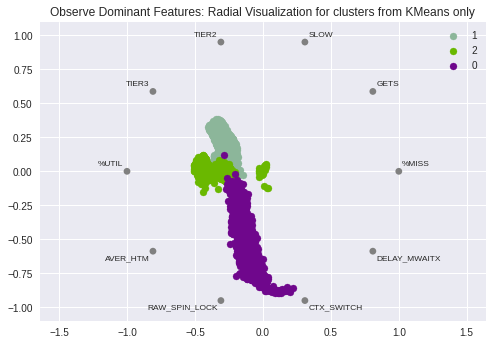

In [46]:
kmeans14 = KMeans(n_clusters=3, init='k-means++', max_iter=600, n_init=10)
kmeans14.fit(DF_train)

df_km = DF_train.copy()
# df_km = df_km_cp[['GETS', 'TIER2', 'TIER3', 'SLOW', 'AVER_HTM', 'RW_SPIN_LOCK','OMENBLOCKING', 'OMR_SPIN_ACQ', 'CLUSTER_TYPE']]
df_km['CLUSTER_TYPE'] = pd.Series(kmeans14.labels_, index=df_km.index)

# df_km_copy.head(20)
plt.title("Observe Dominant Features: Radial Visualization for clusters from KMeans only")
pd.plotting.radviz(df_km, 'CLUSTER_TYPE')

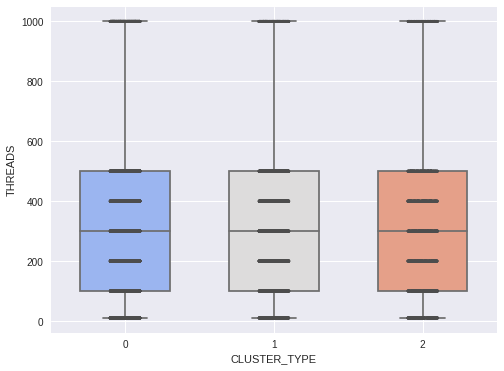

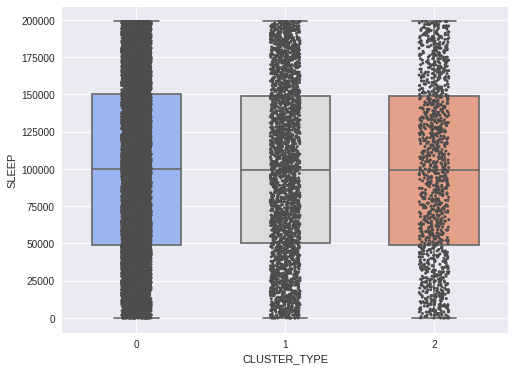

In [113]:
df_box1 = DF1.copy()
# df_box1.head()
x = 'CLUSTER_TYPE'
cols = ['THREADS', 'SLEEP']

for col in cols:
    f, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(y=col, x=x, data=df_box1,
                whis=[0, 100], width=.6, palette="coolwarm")

    # Add in points to show each observation
    sns.stripplot(y=col, x=x, data=df_box1,
                  size=3, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel=col)
    sns.despine(trim=True, left=True)

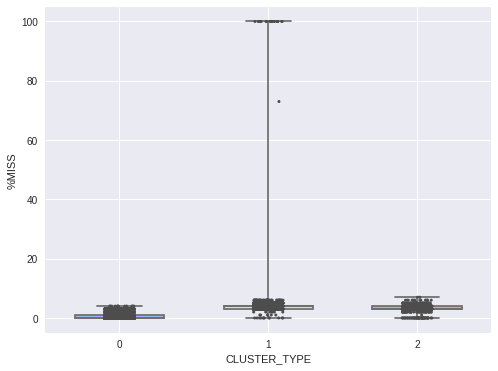

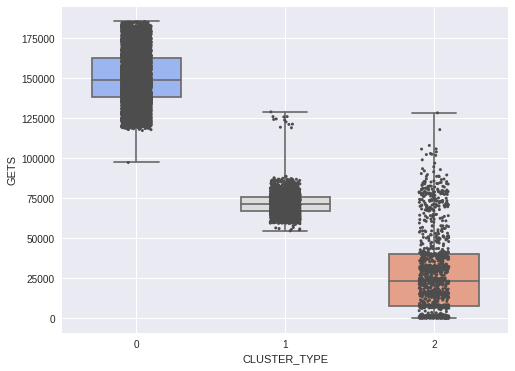

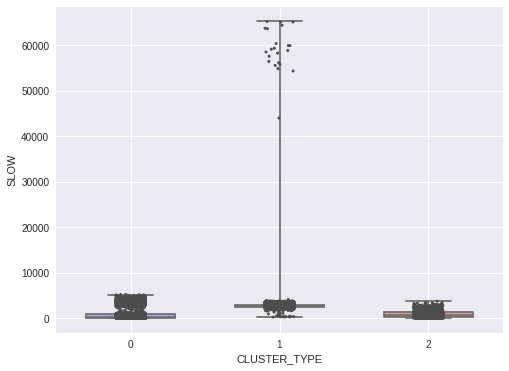

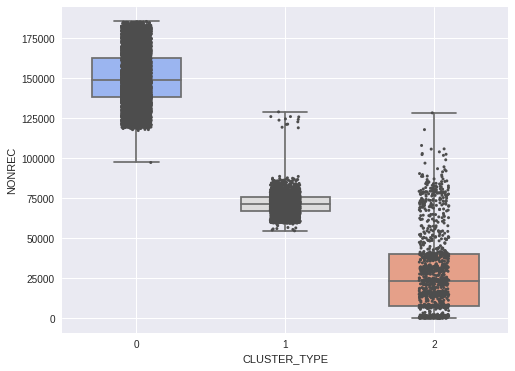

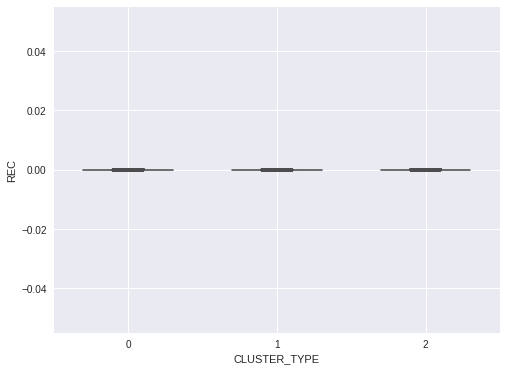

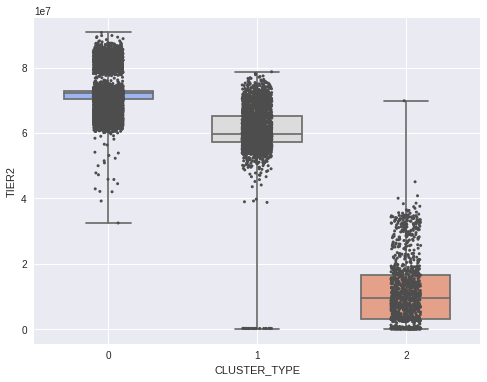

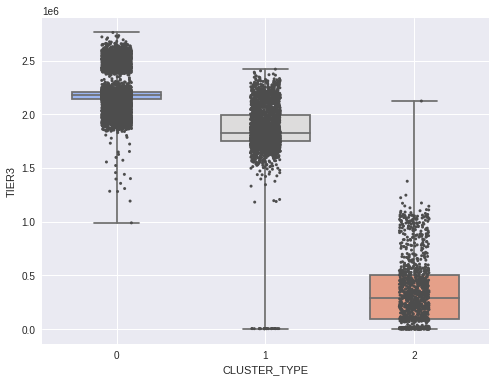

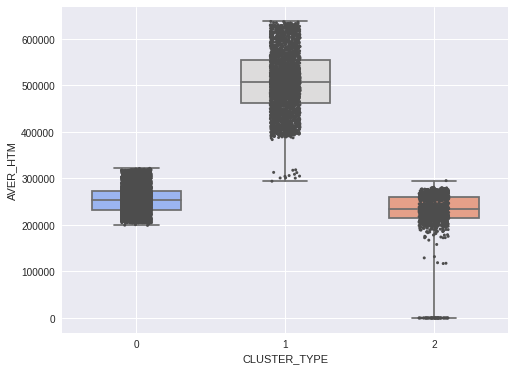

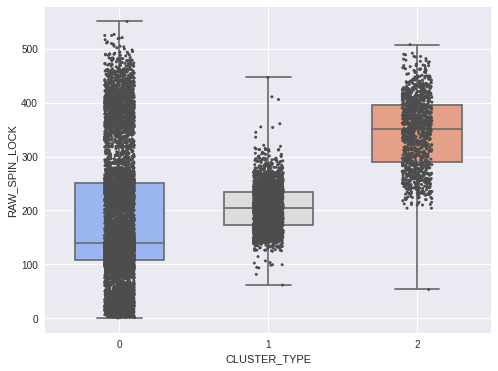

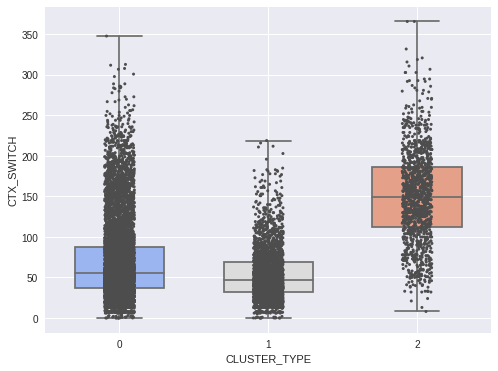

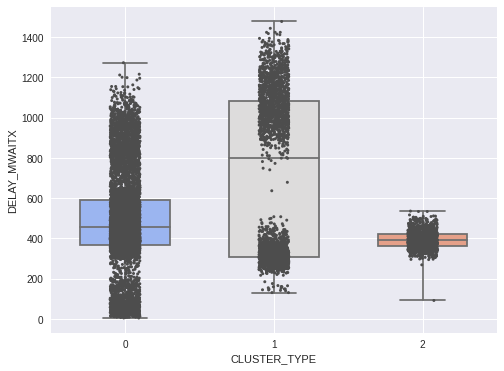

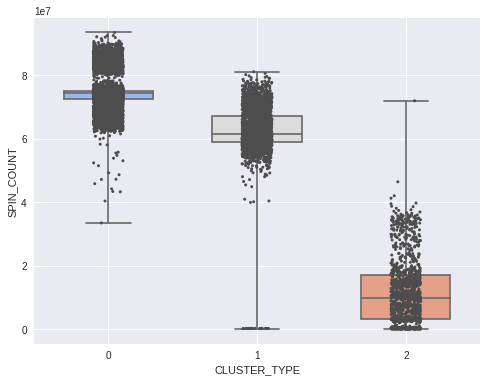

In [111]:
df_box = DF1.copy()
df_box = df_box.drop(['THREADS', 'SLEEP', '%UTIL'], axis=1)

for col in df_box.columns:
    if col is not 'CLUSTER_TYPE':
        x = 'CLUSTER_TYPE'
        y = col
        f, ax = plt.subplots(figsize=(8, 6))
        sns.boxplot(y=y, x=x, data=df_box,
                    whis=[0, 100], width=.6, palette="coolwarm")

        # Add in points to show each observation
        sns.stripplot(y=y, x=x, data=df_box,
                      size=3, color=".3", linewidth=0)

        # Tweak the visual presentation
        ax.xaxis.grid(True)
        ax.set(ylabel=col)
        sns.despine(trim=True, left=True)

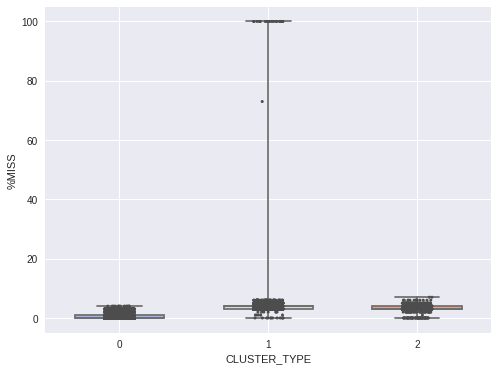

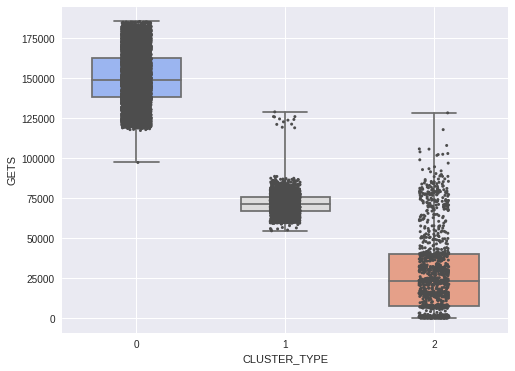

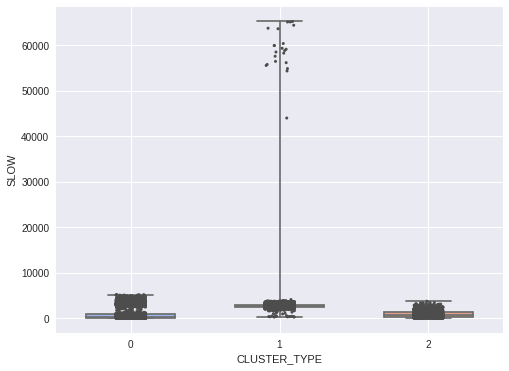

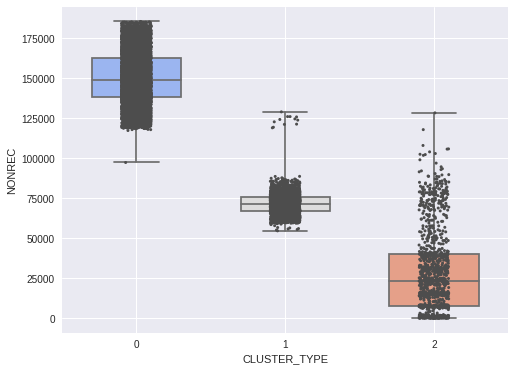

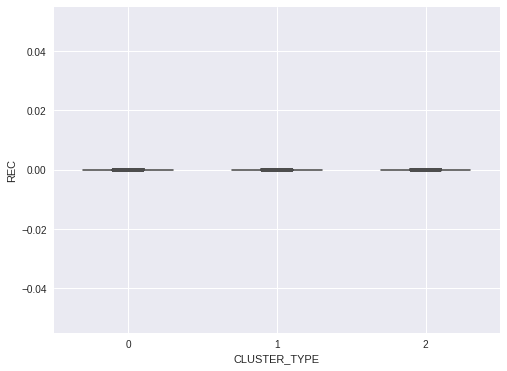

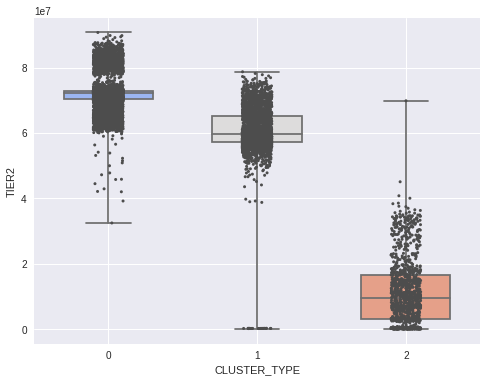

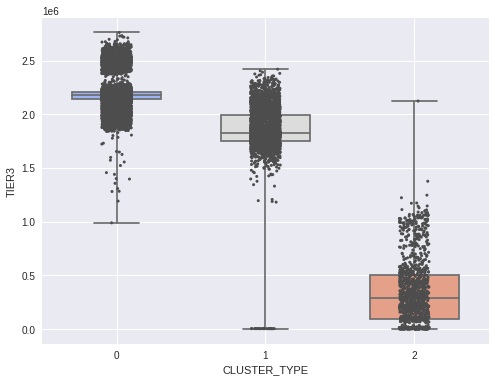

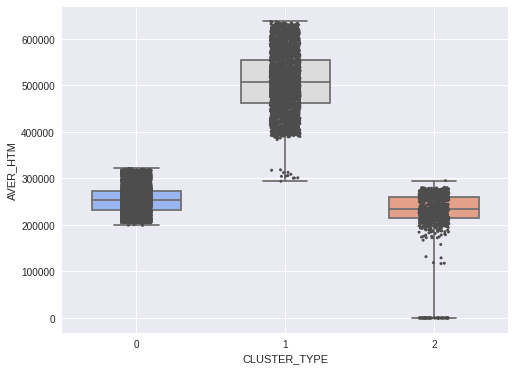

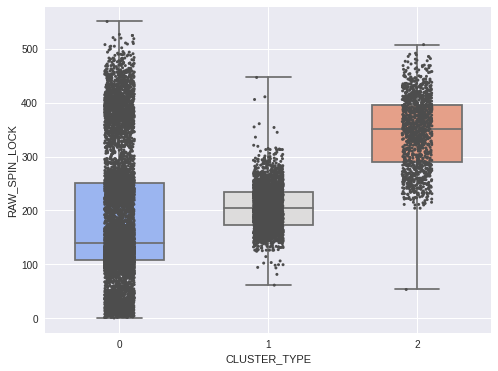

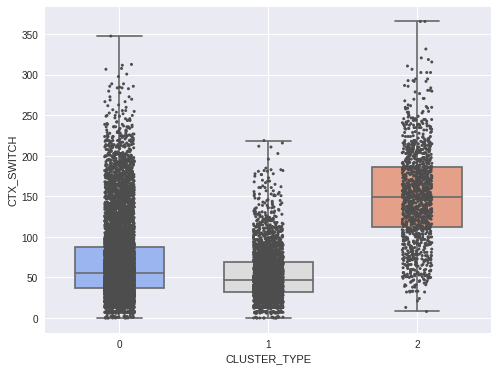

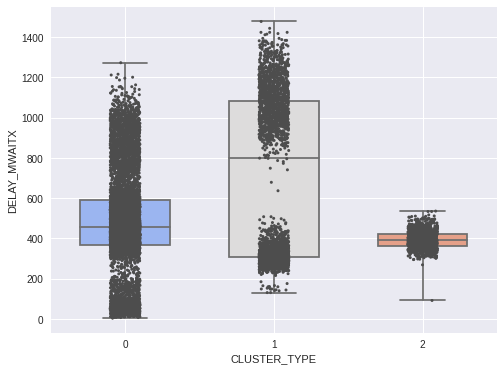

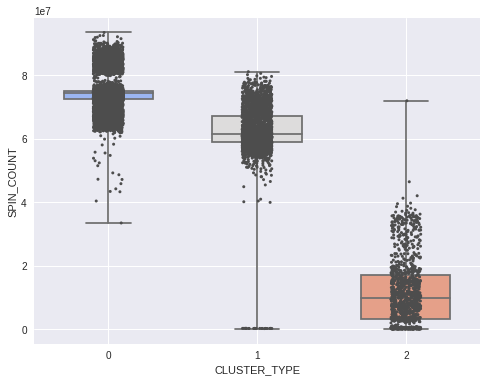

In [114]:
df_box = DF1.copy()
df_box = df_box.drop(['THREADS', 'SLEEP', '%UTIL'], axis=1)

for col in df_box.columns:
    if col is not 'CLUSTER_TYPE':
        x = 'CLUSTER_TYPE'
        y = col
        f, ax = plt.subplots(figsize=(8, 6))
        sns.boxplot(y=y, x=x, data=df_box,
                    whis=[0, 100], width=.6, palette="coolwarm")

        # Add in points to show each observation
        sns.stripplot(y=y, x=x, data=df_box,
                      size=3, color=".3", linewidth=0)

        # Tweak the visual presentation
        ax.xaxis.grid(True)
        ax.set(ylabel=col)
        sns.despine(trim=True, left=True)

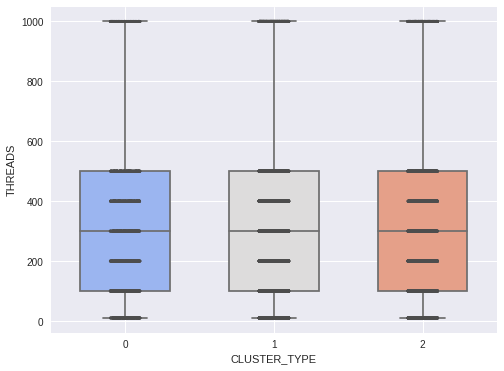

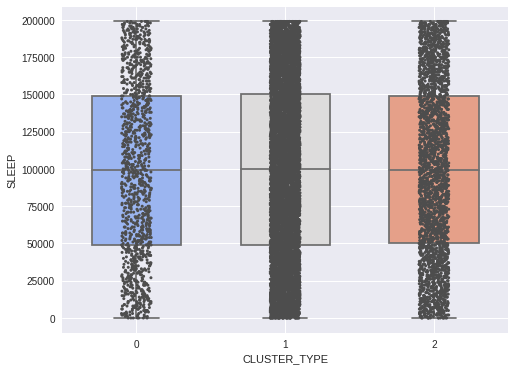

In [98]:
df_box1 = DF1.copy()
# df_box1.head()
x = 'CLUSTER_TYPE'
cols = ['THREADS', 'SLEEP']

for col in cols:
    f, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(y=col, x=x, data=df_box1,
                whis=[0, 100], width=.6, palette="coolwarm")

    # Add in points to show each observation
    sns.stripplot(y=col, x=x, data=df_box1,
                  size=3, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel=col)
    sns.despine(trim=True, left=True)

In [44]:
np.bincount(kmeans12.labels_)

array([11347,  1230,    22])

In [49]:
np.where(kmeans12.labels_==2)

(array([ 4635,  9877,  9941,  9958,  9974, 10064, 10085, 10174, 10270,
        10392, 10436, 10522, 10572, 10665, 10721, 10740, 10827, 10979,
        10985, 11027, 11125, 11174]),)

In [78]:
np.where(DF1.CLUSTER_TYPE==2)


(array([ 4635,  9877,  9941,  9958,  9974, 10064, 10085, 10174, 10270,
        10392, 10436, 10522, 10572, 10665, 10721, 10740, 10827, 10979,
        10985, 11027, 11125, 11174]),)

In [76]:
Cleared=DF1.drop(DF1[DF1.CLUSTER_TYPE==2].index)
Cleared

,%MISS,GETS,SLOW,REC,TIER2,TIER3,%UTIL,AVER_HTM,RAW_SPIN_LOCK,CTX_SWITCH,DELAY_MWAITX,THREADS,SLEEP,CLUSTER_TYPE,CLUSTER_INDEX
0,0,152766,148,0,71701872,2166099,100,247711,319,214,456,300,158001,0,1
1,0,139146,95,0,71079422,2154875,100,272032,342,186,376,500,26001,0,1
2,0,135255,99,0,70971264,2153589,100,279883,342,170,382,400,70001,0,1
3,0,144309,105,0,71853300,2177412,100,262419,392,137,412,1000,1,0,1
4,0,129804,76,0,70814207,2149844,100,291760,405,91,374,1000,178001,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594,0,162521,32,0,72574126,2200552,100,233115,151,64,506,500,18001,0,1
12595,0,155563,58,0,72883925,2187820,100,243600,136,77,784,500,196001,0,1
12596,0,159909,28,0,72340041,2191425,100,236941,127,53,590,10,34001,0,1
12597,0,147096,19,0,72562194,2190847,100,257673,101,55,449,10,119001,0,1


In [77]:
np.where(Cleared.CLUSTER_TYPE==2)

(array([], dtype=int64),)

In [80]:
ClearedPCA=pca_DF_train.drop(DF1[DF1.CLUSTER_TYPE==2].index)
ClearedPCA

,pc1,pc2
0,-0.012565,-1.672460
1,0.067869,-1.475427
2,0.030859,-1.347772
3,-0.148567,-1.348551
4,-0.150050,-0.999571
...,...,...
12594,-1.312691,-0.591888
12595,-1.237223,-0.507259
12596,-1.393797,-0.444162
12597,-1.311926,-0.325118


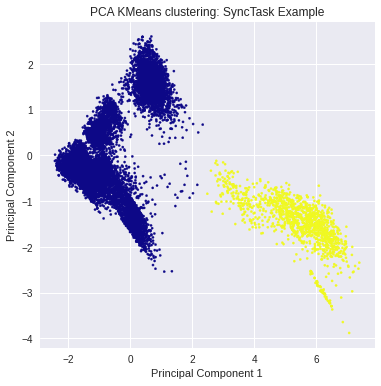

In [82]:
plt.figure(figsize = (6,6))
plt.style.use("seaborn")
plt.scatter(ClearedPCA['pc1'], ClearedPCA['pc2'], c=Cleared.CLUSTER_TYPE, cmap="plasma",s=5)
plt.title('PCA KMeans clustering: SyncTask Example')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()